# Airbnb data analysis
### Questions:
>* What is the price range monthly in each region in Boston and Seattle?
>
>* What is the most vibe time in each region in Boston and Seattle?
>  
>* Can we predict the possible cost as per the corresponding holder's profiles (e.g., region, ratings, and month and day)?

# Load data

In [1]:
# set data location
data_dir = '../../Datasets/'
boston_dir = data_dir+"Boston Airbnb Open Data/"
seattle_dir = data_dir+'Seattle_Airbnb/'

In [2]:
import os
# all boston datasets and seattle datasets
bs_all,sa_all = [],[]
for root,dirs,files in os.walk(boston_dir):
    for file in files:
        bs_all.append(os.path.join(root,file))
for root,dirs,files in os.walk(seattle_dir):
    for file in files:
        sa_all.append(os.path.join(root,file))

> ## Load all datasets

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
# change number format on the display to avoid complicated scientific numbers
def format_float(x):
    if x.is_integer():
        return '{:.0f}'.format(x)  # Format integers without decimal places
    else:
        return '{:.1f}'.format(x)  # Format floats with 5 decimal places
pd.set_option('display.float_format', format_float)

In [4]:
# since both datasets contain 'reviews','listings', and 'calendar', create a dictionary key
dict_keys = ['reviews','listings','calendar']
# create dictionary of dataframes for both boston and seattle
dict_bs, dict_sa = {}, {}
for i,dict_key in enumerate(dict_keys):
    dict_bs[dict_key] = pd.read_csv(bs_all[i])
    dict_sa[dict_key] = pd.read_csv(sa_all[i])

## Wrangle data

> The data size is very large, directly merging will be too huge. Drop the non-essential columns and decrease the granuarity of the data.
>
> Focusing on the three questions shown above, NLP is not necessarily efficient in the case that the numerical ratings are given. Therefore, NLP remains to be optional for further analysis including keywords extraction and word vectorisation.

In [5]:
# save the dataframe for wrangling
ls_bs, ls_sa, cd_bs, cd_sa = dict_bs['listings'], dict_sa['listings'], dict_bs['calendar'], dict_sa['calendar']

In [6]:
# drop nans
ls_bs.dropna(how='all', axis=1, inplace=True)
ls_sa.dropna(how='all', axis=1, inplace=True)
ls_bs.dropna(how='all', axis=0, inplace=True)
ls_sa.dropna(how='all', axis=0, inplace=True)
# get the common columns for better comparision
ls_com_col = [col for col in ls_bs.columns if col in ls_sa.columns]
ls_bs, ls_sa = ls_bs[ls_com_col], ls_sa[ls_com_col]

> To address the questions in this investigation, dataframe 'reviews' and NLP are not necessarily to be included.

> check the columns and select the essential columns
> 
> * 'id', 'neighbourhood_cleansed', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',	'review_scores_checkin', 'review_scores_communication',	'review_scores_location', 'review_scores_value', 'reviews_per_month'

In [7]:
select_ls_col = ['id', 'neighbourhood_cleansed', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

In [8]:
ls_bs, ls_sa = ls_bs[select_ls_col], ls_sa[select_ls_col]

> merge the listings and calendar for boston and seattle dataframes

In [9]:
# rename the price columns to avoid name clash
ls_bs.rename(columns={'price':'base_price'},inplace=True)
ls_sa.rename(columns={'price':'base_price'},inplace=True)
df_bs = ls_bs.merge(cd_bs, how='inner', left_on='id', right_on='listing_id')
df_sa = ls_sa.merge(cd_sa, how='inner', left_on='id', right_on='listing_id')
# create an extra column for both
df_bs['city'], df_sa['city'] = 'Boston', 'Seattle'
# drop id
df_bs.drop(columns='id', inplace=True)
df_sa.drop(columns='id', inplace=True)
# merge the two datasets
df = pd.concat([df_bs,df_sa], axis=0)
df.reset_index(inplace=True, drop=True)

> clean up the na values. Although the missing ratings can be filled up by regressing the ratings of each airbnb name, 20% of missing is still okay for this size of data. However, the missing values of prices are over 41%. The value can be regressed by the base_price value 

In [10]:
df.dropna(how='any', subset=['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                             'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                             'review_scores_value','reviews_per_month'], inplace=True)
df.shape

(2158975, 15)

In [11]:
# reformat base_price and price
df['base_price'] = df['base_price'].str.extract(r'(\d+\.\d+)')
df['price'] = df['price'].str.extract(r'(\d+\.\d+)')
df[['base_price','price']] = df[['base_price','price']].astype('float32')
df = df.query('base_price > 0')

In [12]:
# fill the na values in price coln using base_price
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()
indx_missing = df.price.isnull()
x_train, x_test, y_train, y_test = df.base_price[~indx_missing].values.reshape(-1,1), df.base_price[indx_missing].values.reshape(-1,1), \
                                    df.price[~indx_missing], df.price[indx_missing]
lrm.fit(x_train, y_train)
y_pred = lrm.predict(x_test)
df.price[indx_missing] = np.round(y_pred)
df = df.query('price > 0')

In [13]:
# continue to clean and minimise the memory size
df.drop(columns=['listing_id'], inplace=True)
df[['city','neighbourhood_cleansed']]=df[['city','neighbourhood_cleansed']].astype('category')
review_int_cols = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                             'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                             'review_scores_value']
df[review_int_cols] = df[review_int_cols].astype('int8')
df['reviews_per_month'] = df['reviews_per_month'].astype('float16')
# replace column 'available' with 'booked' to show how many bookings
df['booked'] = df.available.apply(lambda x: x=='f').astype('int8')
df.drop(columns='available',inplace=True)

In [14]:
# reformat date
df.date = pd.to_datetime(df.date)
# create new columns for year, month and day
df['year'] = df.date.dt.year.astype('int16')
df['month'] = df.date.dt.month.astype('int8')
df['day'] = df.date.dt.day.astype('int8')
df.drop(columns='date',inplace=True)

In [15]:
df.sample(5)

,neighbourhood_cleansed,base_price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price,city,booked,year,month,day
1787979,Belltown,700,100,10,10,10,10,10,8,0.8,729,Seattle,1,2016,7,31
808396,Fenway,67,89,10,9,10,10,10,9,1.2,78,Boston,1,2017,5,10
2353537,Broadway,180,94,9,9,10,9,10,8,0.5,180,Seattle,0,2016,1,21
253039,North End,150,97,10,10,10,10,10,9,6.9,163,Boston,1,2017,6,3
1717518,Eastlake,59,90,10,10,10,10,9,9,0.2,69,Seattle,1,2016,7,15


In [16]:
df.describe()

,base_price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price,booked,year,month,day
count,2157944,2157944,2157944,2157944,2157944,2157944,2157944,2157944,2157944,2157944,2157944,2157944,2157944,2157944
mean,144.8,93.3,9.5,9.4,9.7,9.7,9.5,9.3,NaN,157.7,0.4,2016.3,6.5,15.8
std,100.1,8.2,0.8,1.0,0.7,0.7,0.8,0.9,0,111.9,0.5,0.5,3.4,8.8
min,11,20,2,2,2,2,2,2,0.0,2,0,2016,1,1
25%,79,91,9,9,10,10,9,9,0.6,85,0,2016,4,8
50%,118,95,10,10,10,10,10,9,1.4,125,0,2016,7,16
75%,180,99,10,10,10,10,10,10,2.9,199,1,2017,10,23
max,999,100,10,10,10,10,10,10,19.2,1036,1,2017,12,31


In [17]:
df.isnull().sum()

neighbourhood_cleansed         0
base_price                     0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
price                          0
city                           0
booked                         0
year                           0
month                          0
day                            0
dtype: int64

## Analyse the data

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

> What is the price range monthly in each region in Boston and Seattle?

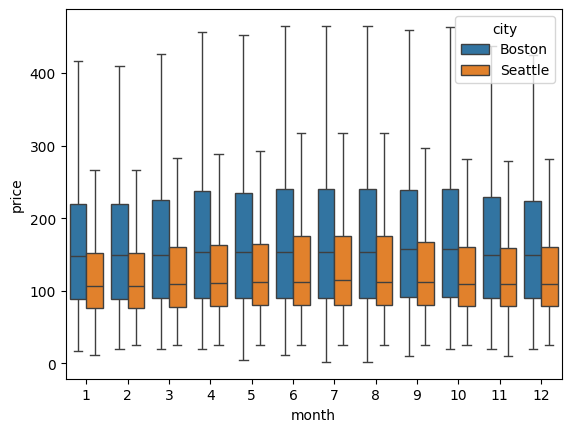

In [17]:
plt.figure()
sns.boxplot(data=df,x='month',y='price',hue='city', showfliers=False)
plt.show()

>What is the most vibe time in each region in Boston and Seattle?

In [65]:
grouped = df.groupby(by=['neighbourhood_cleansed', 'month']).booked.sum()/df.groupby(by=['neighbourhood_cleansed', 'month']).booked.count()*100

In [66]:
grouped = grouped.groupby(level=0).aggregate(['idxmax', 'max'])

In [67]:
grouped['idxmax'] = grouped['idxmax'].apply(lambda x: x[1])

In [68]:
grouped

,idxmax,max
neighbourhood_cleansed,,
Adams,7,41.765705
Alki,1,37.142857
Allston,9,80.018519
Arbor Heights,1,38.888889
Atlantic,1,51.984127
...,...,...
West Woodland,1,51.604938
Westlake,1,40.333333
Whittier Heights,1,47.083333
